In [151]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv ('./dataset/HandInfo.csv')

In [3]:
files = glob('./dataset/Hands/*.jpg')
list_images = []
img_size = 256

for file in files:
    path_file = file.replace("\\","/");
    filename = path_file.split("/")[3]
    img = cv2.imread(path_file)
    resized_img = cv2.resize(img, (img_size, img_size))[...,::-1]
    list_images.append([resized_img, df[df['imageName'] == filename].filter(items = ['gender']).values[0][0]])
    

In [192]:
random.shuffle(list_images)
data = np.array(list_images)

C:\Users\danie\AppData\Local\Temp/ipykernel_6760/3997491373.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(list_images)


C:\Users\danie\Programas\miniconda3\envs\img\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Dataset')

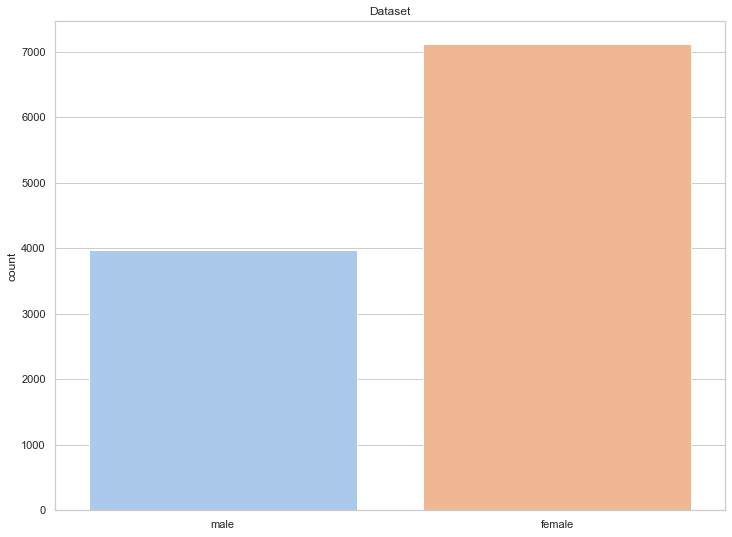

In [193]:
classes = []
m = 0
f = 0
for i in data:
    if(i[1] == 'male'):
        classes.append("male")
        m = m + 1
    else:
        classes.append("female")
        f = f + 1
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(classes).set_title("Dataset")

In [195]:
print("Male {} | Female {}".format(m,f))

Male 3967 | Female 7109


### Balanceamento

In [196]:
drop_index = []
for index, c in enumerate(classes):
    if (c == 'female') and (m * 1.1 < f):
        drop_index.append(index)
        f -= 1  

In [197]:
data_bal = np.delete(data, drop_index, axis=0)
for i in drop_index:
    del classes[i]

In [209]:
print("Male {} | Female {}".format(m,f))

Male 3967 | Female 4363


Text(0.5, 1.0, 'male')

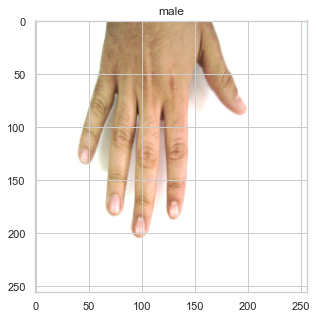

In [200]:
plt.figure(figsize = (5,5))
plt.imshow(data[0][0])
plt.title(data[0][1])

In [201]:
# Female = 4363
# Male   = 3967
# Total  = 8330
# Train  = 6247(F - 3272 | M - 2975)
# Test   = 2083(F - 1091 | M - 992)

In [206]:
x_train, x_test, y_train, y_test = train_test_split(data_bal, classes, train_size=0.75)

In [207]:
len(x_train), len(x_test), len(y_train), len(y_test)

(6247, 2083, 6247, 2083)

C:\Users\danie\Programas\miniconda3\envs\img\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\danie\Programas\miniconda3\envs\img\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\danie\AppData\Local\Temp/ipykernel_6760/3384982516.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


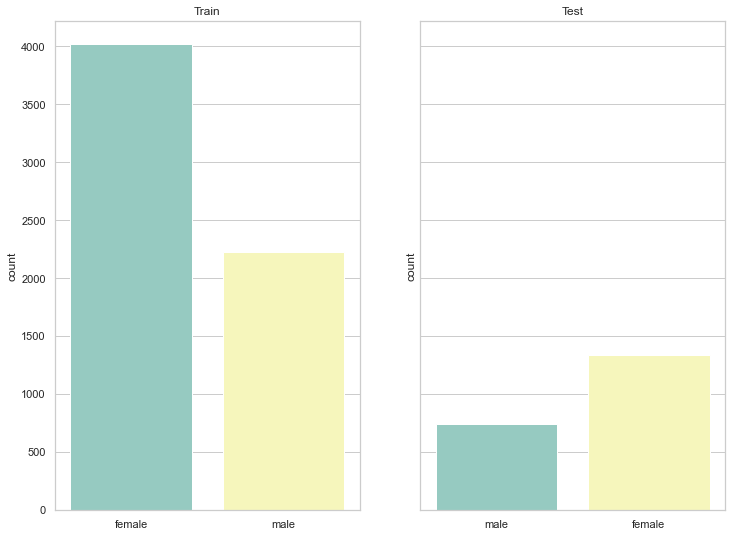

In [208]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.set(rc={'figure.figsize':(12,9)})

sns.set_theme(style="whitegrid", palette="Set3")
sns.countplot(y_train, ax=ax[0]).set_title("Train")

sns.set_theme(style="whitegrid", palette="Set3")
sns.countplot(y_test, ax=ax[1]).set_title("Test")
fig.show()

In [34]:
x_train = np.array([x[0] for x in x_train]) / 255
x_test = np.array([x[0] for x in x_test]) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)